In [1]:
import glob 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading trajectories
In this script, I will read the data generated by the program ImageJ and in particular the plugging TrackMate.

## Automatic approach

In [2]:
def read_trj_and_particles(directory = str, extension = str):
    
    filenames = [file for file in glob.glob(os.path.join(directory,('*'+extension)))]
    
    trj = [pd.read_csv(file, sep =",",skiprows = [1,2,3], index_col = [0], usecols = [2,4,5,8]) 
           for file in filenames]
    
    keys = [df.index.get_level_values('TRACK_ID').unique().values
            for df in trj]
    
    keys = np.concatenate(keys).ravel().tolist()
    keys = np.arange(0,len(keys))
    print(keys)
    trj = pd.concat(trj, keys = keys)
    trj.index.names = ['exp','id']
    trj.sort_values(by = ['exp','id','FRAME'], inplace = True)
    
    return trj

In [3]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/PDMS_chips/16-02-2023/Pre-treated-videos/3ul-min"
trj = read_trj_and_particles(directory, '.csv')

[0 1 2 3 4 5 6]


In [4]:
def v(df,frame_rate = float , pix = float, um = float):   
#     print(df)
    delta_r = [0]

    for i in range(0,len(df)-1):
        j = i+1  
        delta_r.append(np.sqrt((df.iloc[j].POSITION_X-df.iloc[i].POSITION_X)**2+(df.iloc[j].POSITION_Y-df.iloc[i].POSITION_Y)**2))
    
    df['y'] = df['POSITION_Y']*(um/pix)  # um/pix from scale bar
    df['delta_r'] = delta_r 
    df['delta_t'] = (frame_rate) # 30 fps
    df['v'] = (df['delta_r']*(um/pix))/df['delta_t'] # um/pix from scale bar
    
    return df

In [5]:
vel = []
for date, new_df in trj.groupby(['exp','id']):

     vel.append(v(new_df, frame_rate = 1/30 , pix = 497.549, um = 1000))
        
vel = pd.concat(vel)

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

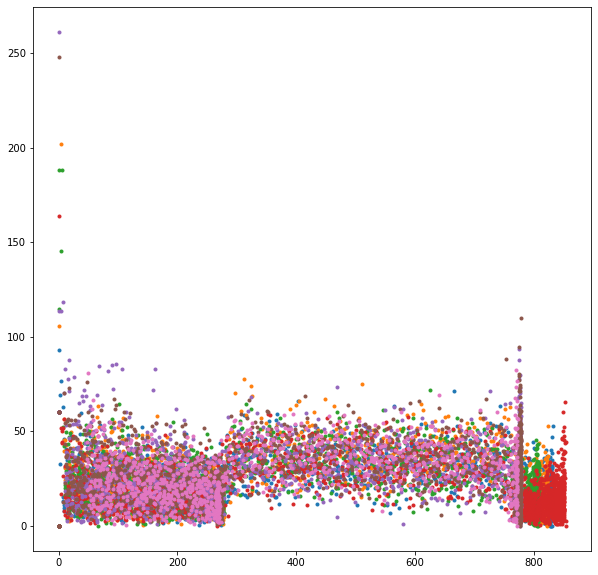

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

grouped = vel.groupby(['exp','id'])

for name,group in grouped:
    plt.plot(group.y, group.v,'.')

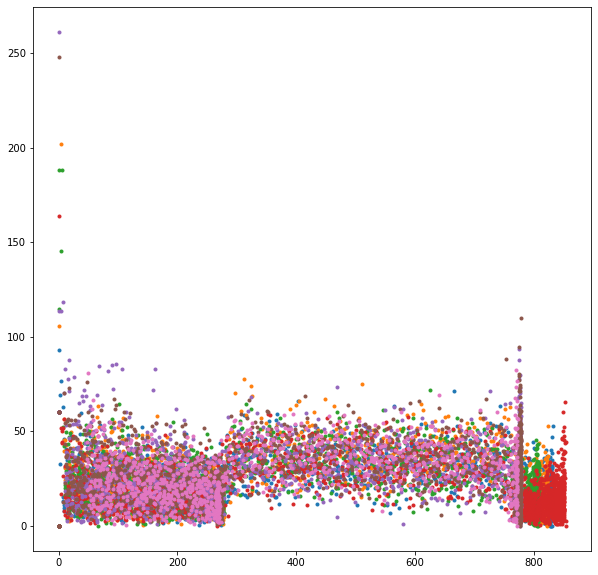

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

grouped = vel.groupby(['exp','id'])

for name,group in grouped:
    plt.plot(group.y, group.v,'.')

Now I only need to compute the mean value of the velocity in the 3 regions: entrance, channel and bifurcation

In [8]:
entrance= 375*1000/497.549
bifurcation = 140*1000/497.549
entrance

753.6946109830388

In [9]:
def channel_v_vs_position(df_particle, entrance = int, bifurcation = int):
    
    string = ('y <= '+str(entrance)+' & y > '+str(bifurcation)+' ')
    
    entrance = df_particle.query('y > '+str(entrance))
    channel = df_particle.query(string)
    bifurcation = df_particle.query('y < '+str(bifurcation))
    
    v_entrance = entrance.loc[:, 'v'].mean()
    v_channel = channel.loc[:, 'v'].mean()
    v_bifurcation = bifurcation.loc[:, 'v'].mean()
    
    #print(v_entrance, v_channel, v_bifurcation)
    
    return v_entrance, v_channel, v_bifurcation

In [10]:
v_mean = []

for date, new_df in vel.groupby(level=[0,1]):

    v_mean.append(channel_v_vs_position(new_df, entrance = entrance, bifurcation = bifurcation))

v_e = [v[0] for v in v_mean]
v_c = [v[1] for v in v_mean]
v_b = [v[2] for v in v_mean]

In [12]:
d = {'v_e': v_e, 'v_c': v_c, 'v_b': v_b}

df = pd.DataFrame(data=d)

df.to_csv('16-02-2023_3ul-min.dat', sep = '\t')

In [13]:
df

,v_e,v_c,v_b
0,15.680540,33.660127,17.766365
1,15.755233,39.334308,20.618738
2,14.162672,34.115381,21.096468
3,13.661792,32.440750,17.534865
4,23.366361,33.652321,24.459993
5,24.519060,37.599544,24.000992
6,28.417337,37.127967,21.041366
